# ***Exploración Inicial y Manejo de Datos Faltantes***

## **1. Importar Datos y librerías**

In [1]:
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import math
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import missingno as msno 
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import BayesianRidge
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = False
import seaborn as sns
import pandas as pd
import scipy.stats as stats
from scipy.stats import kstest, chi2_contingency


sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

En primer lugar, se importan las librerías a usar y la base de datos que se usará en el proyecto.

In [2]:
df = pd.read_csv("vehicles.csv")

## **2. Observación de los datos**

En esta sección, como lo insdica su título, se observarán los datos con el fin de determinar si hay errores de tabulación, NA's, errores en el typo de variables y demás. Solo se miran los datos desde lejos, para luego detallarlos y limpiarlos.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 426880 entries, 0 to 426879
Data columns (total 26 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            426880 non-null  int64  
 1   url           426880 non-null  object 
 2   region        426880 non-null  object 
 3   region_url    426880 non-null  object 
 4   price         426880 non-null  int64  
 5   year          425675 non-null  float64
 6   manufacturer  409234 non-null  object 
 7   model         421603 non-null  object 
 8   condition     252776 non-null  object 
 9   cylinders     249202 non-null  object 
 10  fuel          423867 non-null  object 
 11  odometer      422480 non-null  float64
 12  title_status  418638 non-null  object 
 13  transmission  424324 non-null  object 
 14  VIN           265838 non-null  object 
 15  drive         296313 non-null  object 
 16  size          120519 non-null  object 
 17  type          334022 non-null  object 
 18  pain

En primer lugar, se examina la base de datos en general. Note que la base tiene las siguientes `dimensiones: 426880 filas y 26 columnas`. A simple vista, el comando `.info()` indica que hay ciertas variables con datos faltantes y también se detectan ciertas variables como: `id`, `odometer` y `cylinders` tienen asignado un *tipo de variable que no corresponde con la naturaleza de la variable*. 

In [4]:
pd.set_option('display.max_columns', None)
df.head()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
0,7222695916,https://prescott.craigslist.org/cto/d/prescott...,prescott,https://prescott.craigslist.org,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN,NaN
1,7218891961,https://fayar.craigslist.org/ctd/d/bentonville...,fayetteville,https://fayar.craigslist.org,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN,NaN
2,7221797935,https://keys.craigslist.org/cto/d/summerland-k...,florida keys,https://keys.craigslist.org,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN,NaN
3,7222270760,https://worcester.craigslist.org/cto/d/west-br...,worcester / central MA,https://worcester.craigslist.org,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN,NaN
4,7210384030,https://greensboro.craigslist.org/cto/d/trinit...,greensboro,https://greensboro.craigslist.org,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN,NaN


Observe que solo las 5 primeras columnas cuentan con valores diferentes a NaN, además de la variable state. 

In [5]:
pd.set_option('display.max_columns', None)
df.tail()

,id,url,region,region_url,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,image_url,description,county,state,lat,long,posting_date
426875,7301591192,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,23590,2019.0,nissan,maxima s sedan 4d,good,6 cylinders,gas,32226.0,clean,other,1N4AA6AV6KC367801,fwd,NaN,sedan,NaN,https://images.craigslist.org/00o0o_iiraFnHg8q...,Carvana is the safer way to buy a car During t...,NaN,wy,33.786500,-84.445400,2021-04-04T03:21:31-0600
426876,7301591187,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,30590,2020.0,volvo,s60 t5 momentum sedan 4d,good,NaN,gas,12029.0,clean,other,7JR102FKXLG042696,fwd,NaN,sedan,red,https://images.craigslist.org/00x0x_15sbgnxCIS...,Carvana is the safer way to buy a car During t...,NaN,wy,33.786500,-84.445400,2021-04-04T03:21:29-0600
426877,7301591147,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,34990,2020.0,cadillac,xt4 sport suv 4d,good,NaN,diesel,4174.0,clean,other,1GYFZFR46LF088296,NaN,NaN,hatchback,white,https://images.craigslist.org/00L0L_farM7bxnxR...,Carvana is the safer way to buy a car During t...,NaN,wy,33.779214,-84.411811,2021-04-04T03:21:17-0600
426878,7301591140,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,28990,2018.0,lexus,es 350 sedan 4d,good,6 cylinders,gas,30112.0,clean,other,58ABK1GG4JU103853,fwd,NaN,sedan,silver,https://images.craigslist.org/00z0z_bKnIVGLkDT...,Carvana is the safer way to buy a car During t...,NaN,wy,33.786500,-84.445400,2021-04-04T03:21:11-0600
426879,7301591129,https://wyoming.craigslist.org/ctd/d/atlanta-2...,wyoming,https://wyoming.craigslist.org,30590,2019.0,bmw,4 series 430i gran coupe,good,NaN,gas,22716.0,clean,other,WBA4J1C58KBM14708,rwd,NaN,coupe,NaN,https://images.craigslist.org/00Y0Y_lEUocjyRxa...,Carvana is the safer way to buy a car During t...,NaN,wy,33.779214,-84.411811,2021-04-04T03:21:07-0600


Podemos observar la presencia de valores faltantes en nuestras variables. En particular, la variable `cylinders` se identifican registros con la estructura ***#numero***_**cylinders**, lo cual requieren ser transformados para su adecuado tratamiento, dado que en este estudio será analizada como una variable numérica.

## **3. Limpieza de datos**

### ***3.1. Elimicación de variables irrelevantes***

In [6]:
df=df.drop([ "url", "region_url", "image_url", "description", "posting_date", "id"],axis=1)

pd.set_option('display.max_columns', None)
df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,VIN,drive,size,type,paint_color,county,state,lat,long
0,prescott,6000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN
1,fayetteville,11900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN
2,florida keys,21000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN
3,worcester / central MA,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN
4,greensboro,4900,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN


### ***3.2. Transformación de variables:*** 

En esta sección se corregirá la tabulación de la variable `cylinders`. En el vistazo que se le hizo a la base de datos, se encontró que esta variable debe ser de naturaleza numérica, pero esta está digitada por catgorías, por lo que se corregirá la tabulación.

In [7]:
df["cylinders"].unique()

array([nan, '8 cylinders', '6 cylinders', '4 cylinders', '5 cylinders',
       'other', '3 cylinders', '10 cylinders', '12 cylinders'],
      dtype=object)

In [8]:
def resumen_categorias(df, columna):
    conteo = df[columna].value_counts(dropna=False)
    porcentaje = (conteo / len(df)) * 100

    tabla = pd.DataFrame({
        'Conteo': conteo,
        'Porcentaje (%)': porcentaje.round(2)
    })

    return tabla

In [9]:
resumen_categorias(df,"cylinders")

,Conteo,Porcentaje (%)
NaN,177678,41.62
6 cylinders,94169,22.06
4 cylinders,77642,18.19
8 cylinders,72062,16.88
5 cylinders,1712,0.40
10 cylinders,1455,0.34
other,1298,0.30
3 cylinders,655,0.15
12 cylinders,209,0.05


Note que efectivamene esta variable se encuentra digitada por categorías.

In [10]:
df['cylinders'] = df['cylinders'].replace('other', np.nan)

df['cylinders'] = (
    df['cylinders']
    .str.extract(r'(\d+)')   
    .astype(float)          
)

df['cylinders'] = df['cylinders'].astype('Int64')

resumen_categorias(df,"cylinders")

,Conteo,Porcentaje (%)
NaN,178976,41.93
6,94169,22.06
4,77642,18.19
8,72062,16.88
5,1712,0.4
10,1455,0.34
3,655,0.15
12,209,0.05


Para reescribir esta variable como una numérica, se tomó la categoría `other` como NA's y se extrajo la palabra cylenders de cada categoría. Finalmente se le asignó el tipo de variable `int64`.

### ***3.3. Identificación, análisis y tratamiento de valores faltantes***

Para iniciar con este análisis, procederemos a observar de forma gráfica la proporción de valores faltantes en cada variable, utilizando un mapa de calor.

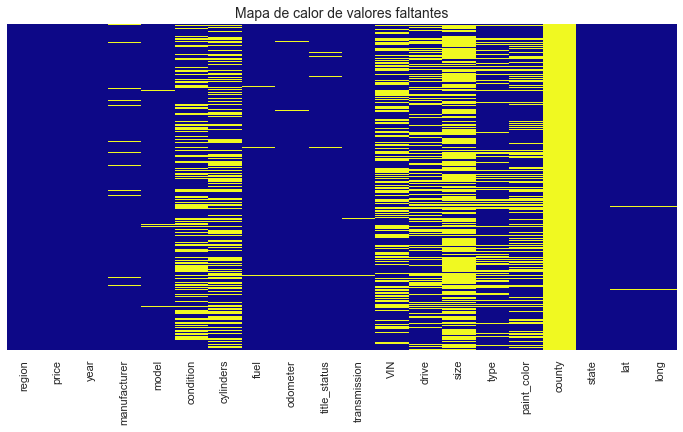

In [11]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='plasma')
plt.title("Mapa de calor de valores faltantes", fontsize=14)
plt.show()

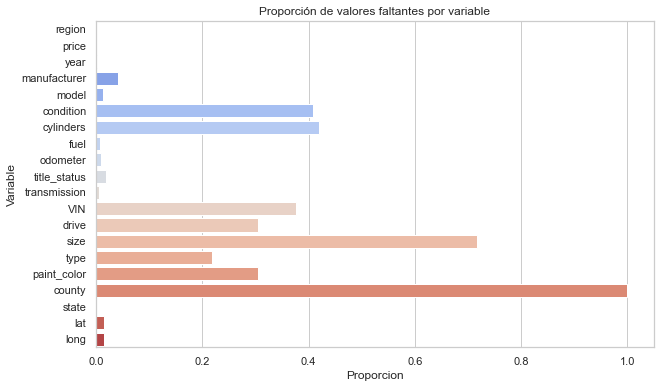

In [12]:
missing = df.isnull().mean().reset_index()
missing.columns = ["Variable", "Proporcion"]

plt.figure(figsize=(10,6))
sns.barplot(x="Proporcion", y="Variable", data=missing, palette="coolwarm")
plt.title("Proporción de valores faltantes por variable")
plt.show()

In [13]:
def resumen_faltantes(df):
    faltantes = df.isnull().sum()
    porcentaje = (faltantes / len(df)) * 100

    tabla_faltantes = pd.DataFrame({
        'Valores faltantes': faltantes,
        'Porcentaje (%)': porcentaje
    })

    tabla_faltantes = tabla_faltantes[tabla_faltantes['Valores faltantes'] > 0]

    tabla_faltantes = tabla_faltantes.sort_values('Porcentaje (%)', ascending=False)

    return tabla_faltantes

In [14]:
resumen_faltantes(df)

,Valores faltantes,Porcentaje (%)
county,426880,100.000000
size,306361,71.767476
cylinders,178976,41.926537
condition,174104,40.785232
VIN,161042,37.725356
drive,130567,30.586347
paint_color,130203,30.501078
type,92858,21.752717
manufacturer,17646,4.133714
title_status,8242,1.930753


Al analizar los valores faltantes del dataset, se puede observar que algunas variables presentan un porcentaje considerable de datos ausentes, lo cual puede tener implicancias importantes en el análisis posterior. La variable con mayor cantidad de valores faltantes es **"county"**, con el 100% de los datos ausentes, por lo que resulta completamente inutilizable en su estado actual. Le siguen variables como **"size"**, **"cylinders"**, **"condition"**, y **"VIN"**, con proporciones de datos faltantes superiores al 30%, lo cual plantea un desafío importante en cuanto a imputación o posible eliminación, dependiendo del análisis que se quiera realizar. Otras variables como **"drive"**, **"paint_color"** y **"type"** también muestran una cantidad significativa de valores faltantes, aunque en menor medida. En contraste, hay variables como **"year"**, **"transmission"**, **"fuel"**, y **"odometer"** que presentan muy pocos valores faltantes (menos del 2%), por lo que podrían ser fácilmente imputadas sin generar un sesgo importante. 

### ***3.3.1. Eliminicación de variables: `country` y `size`:***

Dado el alto porcentaje de valores faltantes recurrimos a eliminar estas variables de nuestro análisis.

In [15]:
df=df.drop(["county","size","VIN"],axis=1)

In [16]:
pd.set_option('display.max_columns', None)
df.head()

,region,price,year,manufacturer,model,condition,cylinders,fuel,odometer,title_status,transmission,drive,type,paint_color,state,lat,long
0,prescott,6000,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,az,NaN,NaN
1,fayetteville,11900,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ar,NaN,NaN
2,florida keys,21000,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fl,NaN,NaN
3,worcester / central MA,1500,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ma,NaN,NaN
4,greensboro,4900,NaN,NaN,NaN,NaN,<NA>,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nc,NaN,NaN


A continuación, se analiza más de cerca sobre los valores faltantes en cada una de las variables.

### ***3.3.2. Variables con un rango de 20% - 40% de valores faltantes***

Antes de iniciar con la imputación de los valores faltantes, se crea una copia del dataframe para luego poder comparar las distribuciones de cada varaible, antes y después de ser imputadas.

In [17]:
df_imputado = df.copy()

#### ***3.3.2.1. `cylinders:`***

In [18]:
resumen_categorias(df,"cylinders")

,Conteo,Porcentaje (%)
NaN,178976,41.93
6,94169,22.06
4,77642,18.19
8,72062,16.88
5,1712,0.4
10,1455,0.34
3,655,0.15
12,209,0.05


La variable **"cylinders"** presenta un alto porcentaje de valores faltantes, con un 41.93% de los datos ausentes, lo cual representa una porción significativa del total del dataset y sugiere la necesidad de una estrategia cuidadosa para el tratamiento de estos valores. Entre las categorías presentes, la más común es la de vehículos con **6 cilindros**, representando el **22.06%**, seguida por los de **4 cilindros** con un **18.19%**, y los de **8 cilindros** con un **16.88%**. Estas tres categorías concentran la gran mayoría de los datos observados, lo que indica una clara preferencia o predominancia de motores con configuraciones comunes en el mercado. Las demás categorías, como los vehículos con **5, 10, 3 y 13 cilindros**, tienen una frecuencia muy baja, con porcentajes que no superan el 0.4%, por lo que podrían ser consideradas como casos poco representativos o incluso atípicos. 

In [19]:
original = df_imputado["cylinders"].dropna()

Se toma los valores originales de la variable a tratar.

In [20]:
num_cols = df_imputado.select_dtypes(include=["int64", "float64"]).columns.tolist()
other = [c for c in num_cols if c != "cylinders"]

Primero, se seleccionan las columnas numéricas del DataFrame original, excluyendo específicamente la columna `"cylinders"`, ya que esa será la variable objetivo que se desea imputar. Se guardan en la lista `other` las demás columnas numéricas que podrían usarse como predictores para la imputación.

In [21]:
imp = IterativeImputer(estimator=BayesianRidge(), max_iter=10, random_state=42)
X_imp = pd.DataFrame(imp.fit_transform(df_imputado[other]), columns=other, index=df_imputado.index)

A continuación, se utiliza un `IterativeImputer` con regresión bayesiana (`BayesianRidge`) como estimador para completar los valores faltantes en las columnas numéricas seleccionadas (excluyendo "cylinders"). El resultado es un nuevo DataFrame `X_imp`, con los valores imputados para todas las columnas predictoras.

In [22]:
known = df_imputado["cylinders"].notna()
y = df_imputado.loc[known, "cylinders"].astype(int)

clf = RandomForestClassifier(n_estimators=200, random_state=42)
clf.fit(X_imp.loc[known], y)

RandomForestClassifier(n_estimators=200, random_state=42)

Luego se define el conjunto de datos conocidos (aquellos donde "cylinders" no es nulo) y se extrae el vector objetivo `y`, que contiene los valores de cilindros convertidos a enteros. Posteriormente, se entrena un modelo de clasificación con un `RandomForestClassifier`, usando 200 árboles y una semilla aleatoria para reproducibilidad. Este modelo se ajusta con las variables predictoras (`X_imp`) y el vector objetivo `y`, solo sobre las filas conocidas.

In [23]:
missing = ~known
proba = clf.predict_proba(X_imp.loc[missing])
classes = clf.classes_

rng = np.random.default_rng(42)
samples = [rng.choice(classes, p=p) for p in proba]

Una vez entrenado el modelo, se predicen las probabilidades de clase para los casos en los que el número de cilindros es desconocido (filas con valores faltantes). Se extraen también las clases posibles del modelo. Luego, utilizando una semilla aleatoria, se realiza una selección aleatoria ponderada (sampling) sobre esas probabilidades para elegir una clase por fila, respetando la distribución probabilística dada por el modelo.

In [24]:
df_imputado.loc[missing, "cylinders"] = samples
df_imputado["cylinders"] = df_imputado["cylinders"].astype("Int64")

# Serie con la columna imputada
imputados = df_imputado["cylinders"]

Se asignan los valores imputados a las filas faltantes de la columna "cylinders", y se asegura que toda la columna sea del tipo entero. El resultado final se guarda en la variable `imputados`, que contiene la columna completa de cilindros, ya sin valores faltantes.

In [25]:
hay_na = df_imputado['cylinders'].isnull().values.any()
print(f"¿Hay NA en columnas imputadas? {hay_na}")

na_por_col = df_imputado['cylinders'].isnull().sum()
print("Conteo de NA por columna imputada:")
print(na_por_col)

¿Hay NA en columnas imputadas? False
Conteo de NA por columna imputada:
0


Finalmente se observa que la columna `cylinders` ya no tiene valores faltantes.

In [26]:
def comparar_imputacion(original, imputada, variable_name='Variable'):
    
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    sns.histplot(original.dropna(), kde=True, color='skyblue', bins=30)
    plt.title(f'{variable_name} - Original (sin NaNs)')
    plt.xlabel(variable_name)
    plt.ylabel('Frecuencia')

    plt.subplot(1, 2, 2)
    sns.histplot(imputada, kde=True, color='salmon', bins=30)
    plt.title(f'{variable_name} - Imputada')
    plt.xlabel(variable_name)
    plt.ylabel('Frecuencia')

    plt.tight_layout()
    plt.show()


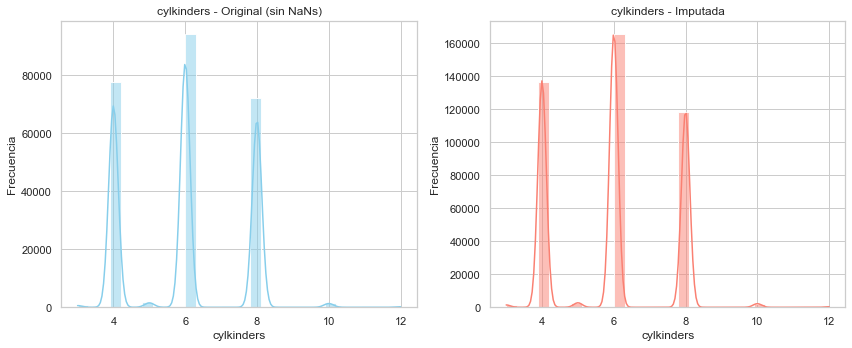

In [27]:
comparar_imputacion(df['cylinders'], df_imputado['cylinders'], variable_name='cylkinders')

En la visualización se comparan las distribuciones de la variable **"cylinders"** antes y después del proceso de imputación. En el gráfico de la izquierda se observa la distribución original de los datos sin valores nulos, donde predominan claramente tres categorías: 4, 6 y 8 cilindros, con picos muy marcados que reflejan su alta frecuencia en el conjunto de datos. En el gráfico de la derecha, que muestra los datos una vez imputados, se puede apreciar que la distribución general se ha mantenido prácticamente idéntica. Esto indica que el modelo de imputación basado en Random Forest logró preservar la estructura original de la variable, asignando valores faltantes de manera coherente con las tendencias observadas. La similitud entre ambas distribuciones sugiere que el modelo no introdujo sesgos significativos ni distorsiones en la frecuencia de cada categoría. En general, la imputación fue exitosa, ya que respetó las proporciones naturales de los datos conocidos y completó la variable de forma realista.

In [28]:
from scipy.stats import chi2_contingency

dist_original = original.value_counts()
dist_imputada = imputados.value_counts()

contingencia = pd.concat(
    [dist_original, dist_imputada], 
    axis=1, 
    keys=["Original", "Imputado"]
).fillna(0).astype(int)

chi2, p, dof, expected = chi2_contingency(contingencia)

print(f"Chi² = {chi2:.3f}, p-valor = {p:.4f}")

Chi² = 188.607, p-valor = 0.0000


**Interpretación de la prueba Chi-cuadrado**

La prueba **Chi-cuadrado de homogeneidad** se utilizó para comparar la distribución original de la variable *cylinders* con la distribución obtenida tras la imputación.

- **Hipótesis nula (H₀):** no hay diferencia entre ambas distribuciones.  
- **Hipótesis alternativa (H₁):** existe diferencia entre las distribuciones.  

En este análisis se obtuvo:  
chi^2 = 192.491, p-value = 0

Esto significa que se **rechaza la hipótesis nula** y se concluye que existen diferencias estadísticamente significativas entre las distribuciones.  

Sin embargo, debido al **tamaño de la muestra**, el test puede detectar como significativas diferencias muy pequeñas. Por esta razón, se complementa con otras métricas (Jensen–Shannon y KL), que muestran que, a pesar de la significancia estadística, las distribuciones son **prácticamente equivalentes en la práctica**.


In [29]:
import numpy as np
from scipy.spatial.distance import jensenshannon
from scipy.stats import entropy

p = dist_original / dist_original.sum()
q = dist_imputada / dist_imputada.sum()

p, q = p.align(q, fill_value=0)

p = p.to_numpy(dtype=float)
q = q.to_numpy(dtype=float)

epsilon = 1e-10
p += epsilon
q += epsilon

p /= p.sum()
q /= q.sum()

jsd = jensenshannon(p, q)
print(f"Jensen-Shannon distance = {jsd:.4f}")

kl_pq = entropy(p, q)   # KL(p || q)
kl_qp = entropy(q, p)   # KL(q || p)
print(f"KL(p||q) = {kl_pq:.4f}, KL(q||p) = {kl_qp:.4f}")


Jensen-Shannon distance = 0.0123
KL(p||q) = 0.0006, KL(q||p) = 0.0006


**Evaluación de la similitud entre distribuciones**

Además de la prueba Chi-cuadrado, se calcularon métricas de divergencia entre la distribución original de la variable *cylinders* y la distribución obtenida después de la imputación. Estas métricas permiten cuantificar cuán parecidas son ambas distribuciones, más allá de la significancia estadística.

***Jensen–Shannon Distance (JSD)***

La **Jensen–Shannon Distance** es una medida de similitud entre dos distribuciones de probabilidad.  
- Su valor está acotado entre **0 y 1**.  
- **0** indica que las distribuciones son idénticas.  
- Valores pequeños (ej. < 0.05) indican que las distribuciones son **muy similares**.  

 
el resultado obternido sugiere que la distribución de la variable imputada es prácticamente indistinguible de la original.

---

***Kullback–Leibler Divergence (KL)***

La **divergencia de Kullback–Leibler (KL)** mide la diferencia entre dos distribuciones de probabilidad desde el punto de vista de la información.  
- KL(p‖q) indica cuánta información se pierde al aproximar la distribución original (*p*) con la imputada (*q*).  
- KL(q‖p) mide lo contrario.  
- El valor mínimo es **0**, que implica distribuciones idénticas.  
- Valores más grandes indican mayor diferencia.  

En nuestro caso los valores obtenidos son muy cercanos a cero, lo que indica que las distribuciones son prácticamente equivalentes en términos de información.

In [30]:
def comparar_categoricas(df_original, df, columnas):

    for col in columnas:
        plt.figure(figsize=(14,5))
        
        plt.subplot(1, 2, 1)
        sns.countplot(y=df_original[col], order=df_original[col].value_counts().index)
        plt.title(f"{col} - Original (con NA)")
        
        plt.subplot(1, 2, 2)
        sns.countplot(y=df[col], order=df[col].value_counts().index)
        plt.title(f"{col} - Después de imputar")
        
        plt.tight_layout()
        plt.show()

Esta función ayuda a comparar dos dsitribuciones gráficamente, específicamente para comprobar las distribuciones de una variable antes y depués de imputar los datos faltantes.

#### ***3.3.2.2. `condition:`***

En primer lugar, se observa la proporción de cada categoría según el total de los datos de la variable `condition`.

In [31]:
resumen_categorias(df,"condition")

,Conteo,Porcentaje (%)
NaN,174104,40.79
good,121456,28.45
excellent,101467,23.77
like new,21178,4.96
fair,6769,1.59
new,1305,0.31
salvage,601,0.14


Note que la categoría con mayor proporción es `NaN`, es decir, los valores faltantes.

Como `condition` es una variable categórica politómica y los datos faltantes representan más del 40%, se toman los datos faltantes como una categoría con el fin de no perder la información y se decide no imputar porque podría generar overfiting.

In [32]:
df_imputado['condition'] = df_imputado['condition'].fillna("condition_missing")

Se verifica que la nueva categoría se haya creado correctamente y no existan más valores faltantes.

In [33]:
hay_na = df_imputado['condition'].isnull().values.any()
print(f"¿Hay NA en columnas imputadas? {hay_na}")

na_por_col = df_imputado['condition'].isnull().sum()
print("Conteo de NA por columna imputada:")
print(na_por_col)

¿Hay NA en columnas imputadas? False
Conteo de NA por columna imputada:
0


Efectivamente se realizó correctamente el proceso de creación de la nueva categoría. 

Entonces observemos como cambia la distribución de la variable antes y después de la imputación.

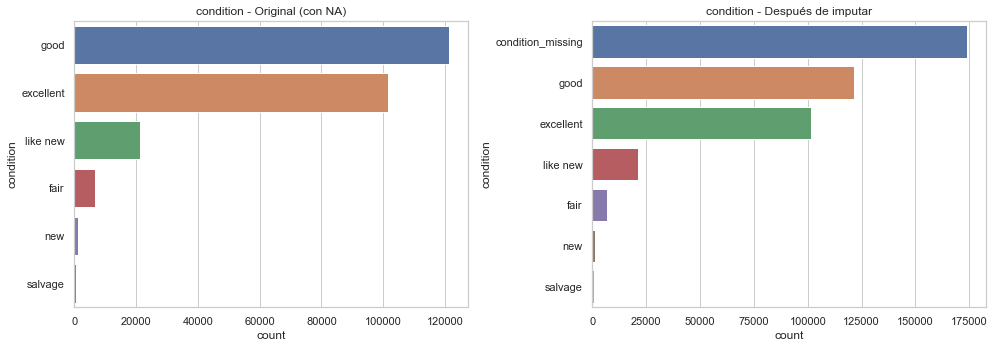

In [34]:
comparar_categoricas(df, df_imputado, ['condition'])

En esta gráfica se compara la distribución de la variable categórica **`condition`** antes y después del proceso de imputación de valores faltantes. En el gráfico de la izquierda, correspondiente a los datos originales, se observa que la categoría predominante es **"good"**, seguida por **"excellent"** y **"like new"**, mientras que algunas observaciones presentan valores ausentes (NA). Tras la imputación, como se muestra en el gráfico de la derecha, se introduce explícitamente una nueva categoría llamada **"condition_missing"** para representar los datos que originalmente estaban ausentes, lo que permite conservar la información sobre la falta de datos sin eliminar registros. Además, se mantiene la misma jerarquía en las frecuencias de las otras categorías, aunque se evidencia un incremento en la frecuencia total, como resultado del tratamiento de los valores faltantes. 

#### ***3.3.2.3. `drive:`***

In [35]:
resumen_categorias(df,"drive")

,Conteo,Porcentaje (%)
4wd,131904,30.90
NaN,130567,30.59
fwd,105517,24.72
rwd,58892,13.80


Se utiliza la función `resumen_categorias` para analizar la variable categórica `drive` dentro del DataFrame `df`. El resultado muestra un conteo y el porcentaje de ocurrencia de cada categoría presente en esta variable. Se observa que hay un valor ausente (`NaN`) que representa el 30.59% del total, casi igual al porcentaje de la categoría más frecuente, `4wd`, que representa el 30.90%. Esto sugiere que una gran proporción de los datos está incompleta en esta variable, lo que justifica la necesidad de una estrategia de imputación.

In [36]:
def imputar_por_moda(df, df_copy, columnas):
    for col in columnas:
        moda = df_copy[col].mode()
        if not moda.empty:
            df_copy[col].fillna(moda[0], inplace=True)
        else:
            print(f"Advertencia: La columna {col} está vacía o no tiene moda.")
    return df_copy

Ahora se define una función llamada `imputar_por_moda` que permite reemplazar los valores nulos en una o más columnas categóricas usando la moda (el valor más frecuente) como criterio de imputación. Esta función toma como entrada el DataFrame original (`df`), una copia del mismo (`df_copy`) y una lista de nombres de columnas a imputar. Para cada columna indicada, se calcula la moda; si existe, se rellena con ese valor, y si no hay moda (por ejemplo, si la columna está vacía), se muestra una advertencia. Finalmente, la función devuelve el DataFrame modificado.

In [37]:
df_imputado['drive'] = df_imputado['drive'].fillna("drive_missing")

Luego se aplica una imputación directa a la columna `drive` del DataFrame `df_imputado`, rellenando los valores nulos con una nueva categoría llamada `"drive_missing"`. Esta técnica de imputación permite conservar la información sobre la ausencia de datos sin recurrir a la eliminación de registros ni a una suposición sobre el valor ausente, como podría ser el uso de la moda.

In [38]:
hay_na = df_imputado['drive'].isnull().values.any()
print(f"¿Hay NA en columnas imputadas? {hay_na}")

na_por_col = df_imputado['drive'].isnull().sum()
print("Conteo de NA por columna imputada:")
print(na_por_col)

¿Hay NA en columnas imputadas? False
Conteo de NA por columna imputada:
0


Y se verifica que la imputación realizada en la columna `drive` fue exitosa. Primero, se evalúa si aún existen valores nulos en la columna mediante la función `isnull().values.any()`, lo cual devuelve `False`, indicando que no hay valores ausentes. Luego, se cuenta explícitamente la cantidad de valores nulos restantes con `isnull().sum()`, que arroja como resultado 0. Esto confirma que todos los valores `NaN` en la columna fueron reemplazados correctamente durante el proceso de imputación.

In [39]:
def comparar_categoricas(df_original, df, columnas):

    for col in columnas:
        plt.figure(figsize=(14,5))
        
        plt.subplot(1, 2, 1)
        sns.countplot(y=df_original[col], order=df_original[col].value_counts().index)
        plt.title(f"{col} - Original (con NA)")
        
        plt.subplot(1, 2, 2)
        sns.countplot(y=df[col], order=df[col].value_counts().index)
        plt.title(f"{col} - Después de imputar")
        
        plt.tight_layout()
        plt.show()

Se define una función que permite visualizar comparativamente la distribución de variables categóricas antes y después de realizar una imputación. 

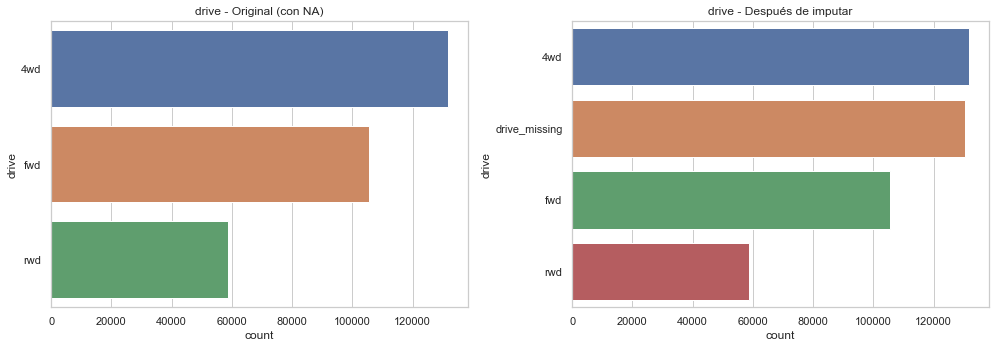

In [40]:
comparar_categoricas(df, df_imputado, ['drive'])


Se realiza una comparación gráfica de la variable `drive` utilizando la función anterior. En el gráfico izquierdo se muestra la distribución original, donde las categorías `4wd`, `fwd` y `rwd` son visibles, sin que se representen los valores faltantes de forma explícita. En el gráfico derecho, correspondiente al DataFrame imputado, se observa una nueva categoría denominada `drive_missing`, que agrupa los registros que originalmente tenían valores nulos. La distribución general de las categorías principales se conserva, lo que sugiere que la imputación se realizó de forma controlada, sin afectar sustancialmente la estructura original de los datos.



#### ***3.3.2.4. `paint_color:`***

In [41]:
resumen_categorias(df,"paint_color")

,Conteo,Porcentaje (%)
NaN,130203,30.50
white,79285,18.57
black,62861,14.73
silver,42970,10.07
blue,31223,7.31
red,30473,7.14
grey,24416,5.72
green,7343,1.72
custom,6700,1.57
brown,6593,1.54


Los datos muestran una cantidad considerable de valores ausentes (NaN), que representan aproximadamente el 30.23 % del total, superando incluso a la categoría más frecuente, `white`. Esta observación pone en evidencia la necesidad de tratar los valores faltantes antes de continuar con el análisis.

In [42]:
df_imputado['paint_color'] = df_imputado['paint_color'].fillna("paint_missing")

Auí se imputanlos datos. Esta imputación de los valores nulos en la columna `paint_color` consiste en asignarles una nueva categoría denominada `"paint_missing"`, lo que permite conservar la información sobre la ausencia de datos sin asumir valores arbitrarios ni eliminar registros del conjunto, lo cual resulta útil para mantener la integridad del análisis posterior.

In [43]:
hay_na = df_imputado['paint_color'].isnull().values.any()
print(f"¿Hay NA en columnas imputadas? {hay_na}")

na_por_col = df_imputado['paint_color'].isnull().sum()
print("Conteo de NA por columna imputada:")
print(na_por_col)

¿Hay NA en columnas imputadas? False
Conteo de NA por columna imputada:
0


El resultado indica que no existe ningún valor faltante y que la cantidad de datos ausentes es cero. Esto confirma que el reemplazo fue aplicado correctamente y no quedaron valores sin imputar.

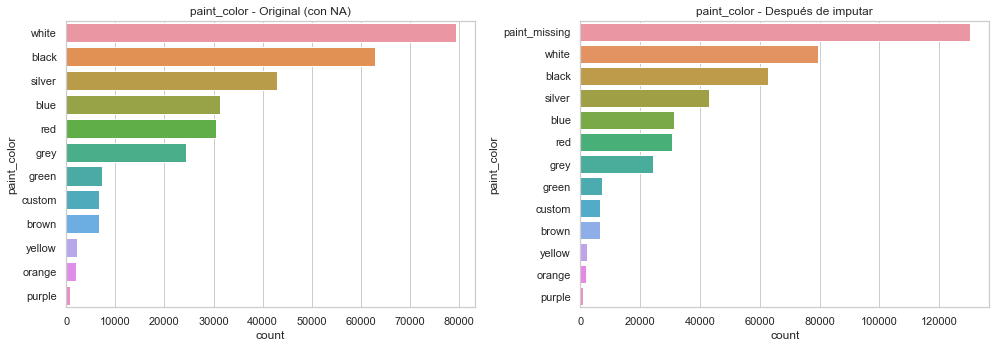

In [44]:
comparar_categoricas(df, df_imputado, ['paint_color'])

La visualización final muestra la comparación entre la distribución original de la variable `paint_color` y la distribución obtenida tras la imputación. En la versión original no aparece una categoría específica para los valores faltantes, mientras que en la versión modificada ya figura `"paint_missing"` como una nueva clase. El resto de las categorías mantiene proporciones similares, lo cual indica que la estructura general de la variable no fue alterada de manera significativa.

#### ***3.3.2.5. `type:`***

In [45]:
resumen_categorias(df,"type")

,Conteo,Porcentaje (%)
NaN,92858,21.75
sedan,87056,20.39
SUV,77284,18.10
pickup,43510,10.19
truck,35279,8.26
other,22110,5.18
coupe,19204,4.50
hatchback,16598,3.89
wagon,10751,2.52
van,8548,2.00


La variable categórica `type` muestra una distribución encabezada por la categoría `sedan`, seguida de `SUV`, `pickup` y `truck`. Sin embargo, una proporción considerable de los registros no cuenta con información en esta variable, lo cual queda evidenciado por los más de 92,000 valores ausentes, que representan un 21.75 % del total. Esta cantidad de datos faltantes justifica la necesidad de aplicar una estrategia de imputación antes de continuar con el análisis.

In [46]:
df_imputado['type'] = df_imputado['type'].fillna("type_missing")

Los valores ausentes de la columna `type` son reemplazados por la etiqueta `"type_missing"`, incorporada como una nueva categoría. Esta forma de imputación permite mantener el tamaño original del conjunto de datos y conservar la información sobre la falta de contenido sin suponer un valor erróneo ni distorsionar las categorías existentes.

In [47]:
hay_na = df_imputado['type'].isnull().values.any()
print(f"¿Hay NA en columnas imputadas? {hay_na}")

na_por_col = df_imputado['type'].isnull().sum()
print("Conteo de NA por columna imputada:")
print(na_por_col)

¿Hay NA en columnas imputadas? False
Conteo de NA por columna imputada:
0


Esta verificación posterior confirma que no quedan datos faltantes en la columna `type` luego de aplicar la imputación. La comprobación lógica devuelve `False`, lo cual indica que no hay valores nulos presentes. Además, el conteo exacto muestra cero registros vacíos, lo que demuestra que la operación fue aplicada correctamente en todos los casos.

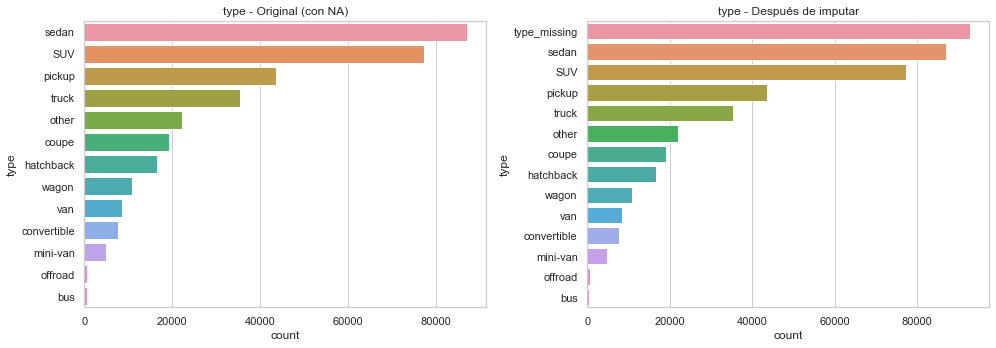

In [48]:
comparar_categoricas(df, df_imputado, ['type'])

Esta visualización final ofrece una comparación entre la distribución original y la modificada de la variable `type`. El gráfico de la izquierda muestra la distribución antes de imputar, sin representar los valores nulos explícitamente. En cambio, el gráfico de la derecha incluye la nueva categoría `"type_missing"`, correspondiente a los registros que originalmente carecían de información. Las proporciones de las demás categorías se mantienen estables, lo que indica que la imputación no alteró la estructura general de la variable.

### ***3.3.3. Variables con menos del 5% de valores faltantes***

***3.3.3.4. Variables numéricas:***

In [49]:
var_low_NA_num = ["lat", "long", "odometer","year"]

La lista `var_low_NA_num` agrupa las variables numéricas del conjunto de datos que presentan un porcentaje bajo de valores faltantes, específicamente menor al 5%. Esta selección permite aplicar un tratamiento diferenciado para valores ausentes en variables donde el problema es poco significativo, evitando imputaciones agresivas que podrían distorsionar los datos originales.

In [50]:
resumen_categorias(df,"lat")

,Conteo,Porcentaje (%)
NaN,6549,1.53
33.779214,3301,0.77
43.182400,2666,0.62
40.468785,2346,0.55
33.786500,2341,0.55
...,...,...
29.016844,1,0.00
35.143705,1,0.00
35.249000,1,0.00
35.123981,1,0.00


La función `resumen_categorias` aplicada sobre la variable `lat` genera un conteo de los valores más frecuentes, junto con su porcentaje sobre el total. Aunque la variable es numérica, el resumen permite identificar rápidamente valores comunes, posiblemente relacionados con coordenadas geográficas repetidas en el conjunto. La presencia de aproximadamente 1.53 % de valores ausentes indica un nivel bajo de incompletitud, lo cual sugiere que una imputación simple o incluso la eliminación de estas pocas filas podría ser una opción viable sin comprometer la representatividad de la muestra.

In [51]:
resumen_categorias(df,"long")

,Conteo,Porcentaje (%)
NaN,6549,1.53
-84.411811,3301,0.77
-84.112200,2666,0.62
-74.281707,2346,0.55
-84.445400,2341,0.55
...,...,...
-95.112076,1,0.00
-93.807449,1,0.00
-94.154610,1,0.00
-94.161800,1,0.00


El análisis aplicado a la variable `long` permite observar una distribución muy similar a la de `lat`, tanto en términos de valores frecuentes como en la proporción de datos ausentes. También aquí, el porcentaje de valores nulos se mantiene en torno al 1.53 %, lo que refuerza la idea de que el impacto de estos valores perdidos sobre el análisis general es mínimo. Este tipo de revisión facilita la toma de decisiones sobre imputación en variables numéricas, especialmente cuando se busca preservar la estructura espacial en conjuntos de datos con información geográfica.

In [52]:
resumen_categorias(df,"odometer")

,Conteo,Porcentaje (%)
NaN,4400,1.03
100000.0,2263,0.53
1.0,2246,0.53
0.0,1965,0.46
200000.0,1728,0.40
...,...,...
149468.0,1,0.00
154259.0,1,0.00
111887.0,1,0.00
213826.0,1,0.00


La variable `odometer`, correspondiente al kilometraje registrado, presenta un bajo porcentaje de valores ausentes (1.03 %). Las observaciones más comunes están concentradas en valores redondos como 100000, 1, y 0, lo cual podría estar relacionado con errores de registro, valores predeterminados o cortes en los datos. La presencia de estas concentraciones sugiere revisar posibles sesgos o problemas de calidad antes de realizar análisis más detallados o aplicar imputaciones.

In [53]:
resumen_categorias(df,"year")

,Conteo,Porcentaje (%)
2017.0,36420,8.53
2018.0,36369,8.52
2015.0,31538,7.39
2013.0,30794,7.21
2016.0,30434,7.13
...,...,...
1943.0,1,0.00
1915.0,1,0.00
1902.0,1,0.00
1905.0,1,0.00


La variable `year` muestra una distribución centrada en años recientes, principalmente entre 2013 y 2018. No se detectan valores faltantes significativos, y aunque existen unos pocos registros con años extremos como 1900 o 1943, estos parecen ser errores o valores atípicos. Esta información ayuda a tener una visión clara del rango temporal cubierto por el dataset, así como de la necesidad de un tratamiento para casos raros o inconsistentes.

In [54]:
def graficar_distribucion(df, columnas):
    for col in columnas:
        plt.figure(figsize=(12, 5))

        plt.subplot(1, 2, 1)
        sns.histplot(df[col].dropna(), kde=True)
        plt.title(f"Histograma: {col}")

        plt.subplot(1, 2, 2)
        stats.probplot(df[col].dropna(), dist="norm", plot=plt)
        plt.title(f"Q-Q Plot: {col}")

        plt.tight_layout()
        plt.show()

La función `graficar_distribucion` permite visualizar la distribución de variables numéricas en dos formas complementarias. Por un lado, genera un histograma con densidad suavizada usando kernel (KDE), útil para observar la forma general de la distribución. Por otro lado, incluye un gráfico Q-Q (Quantile-Quantile), que facilita la evaluación de la normalidad comparando cuantiles teóricos con los observados.

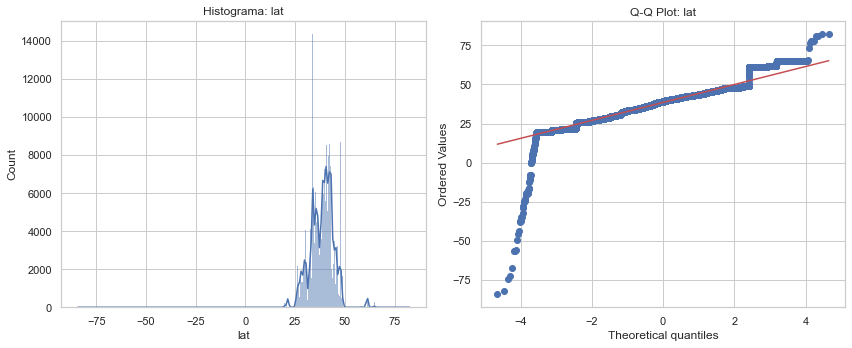

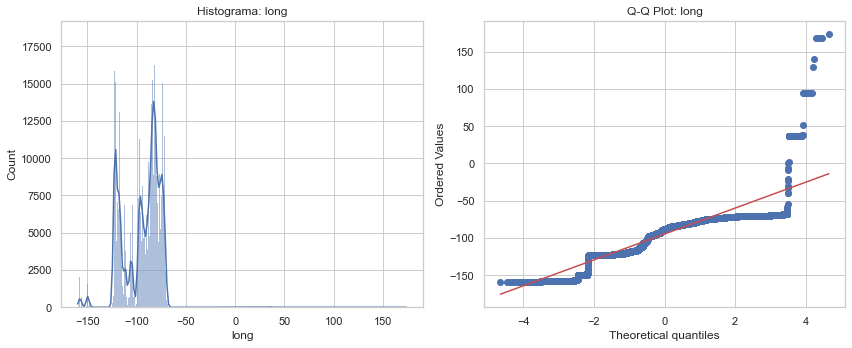

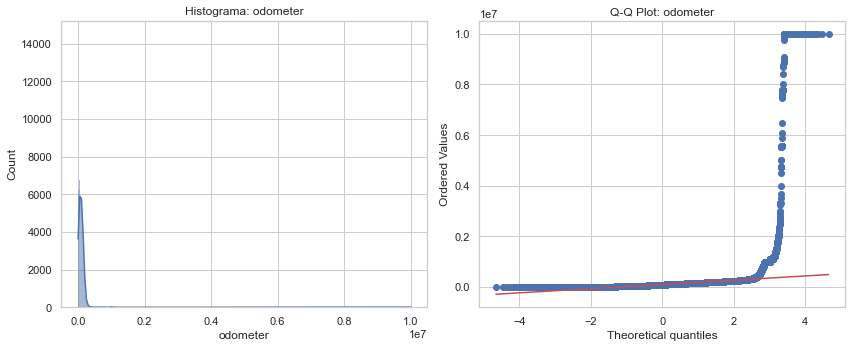

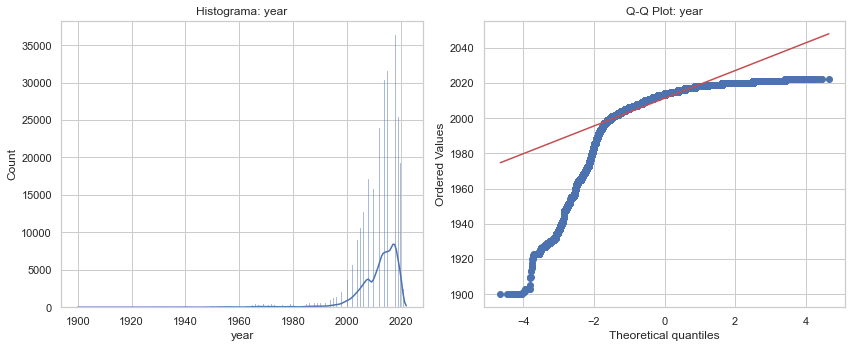

In [55]:
graficar_distribucion(df, var_low_NA_num)

* La distribución de la variable `lat` aparece fuertemente concentrada en un rango estrecho entre aproximadamente 25 y 50, lo que coincide con latitudes de Estados Unidos. El histograma muestra una forma levemente sesgada y con picos, mientras que el gráfico Q-Q refleja desviaciones respecto a la línea teórica, sobre todo en los extremos, lo que indica que los datos no siguen una distribución normal exacta. A pesar de ello, gran parte de los valores se alinean moderadamente bien con los cuantiles teóricos.

* En la variable `long`, la densidad está también fuertemente concentrada, en este caso en valores negativos que reflejan longitudes del hemisferio occidental. El histograma muestra múltiples picos, lo que sugiere la presencia de diferentes regiones geográficas dominantes. El gráfico Q-Q presenta importantes desviaciones, especialmente en las colas, lo que confirma una distribución no normal y la existencia de valores extremos o agrupaciones diferenciadas.

* Los datos de `odometer` muestran una distribución altamente asimétrica, con una gran concentración de vehículos con bajo kilometraje, incluyendo valores como 0 o 1, probablemente introducidos como registros erróneos o predeterminados. El histograma tiene una larga cola hacia la derecha. En el gráfico Q-Q, la curvatura extrema confirma una fuerte desviación de la normalidad, lo cual sugiere que esta variable debería tratarse con transformaciones logarítmicas u otras técnicas si se piensa aplicar algún modelo estadístico sensible a este tipo de distribución.

* La variable `year` evidencia una clara acumulación en años recientes, con una mayor densidad entre 2010 y 2020. El histograma presenta un patrón creciente que refleja la mayor cantidad de registros de autos modernos, mientras que los años anteriores a 1980 aparecen en números insignificantes. El gráfico Q-Q confirma que los datos no tienen un comportamiento normal: existe una marcada curvatura en ambos extremos y un cambio abrupto en la pendiente media, lo que indica que se trata de una distribución sesgada y posiblemente truncada en los años más antiguos.

In [56]:
def test_ks_normalidad(df, columnas, alpha=0.05):
    resultados = {}
    for col in columnas:
        data = df[col].dropna()

        data_std = (data - data.mean()) / data.std()

        stat, p = kstest(data_std, 'norm')
        resultados[col] = {
            "statistic": stat,
            "p-value": p,
            "normal": p > alpha
        }
    return pd.DataFrame(resultados).T


La función `test_ks_normalidad` evalúa si las variables numéricas siguen una distribución normal utilizando la prueba de Kolmogorov-Smirnov. Cada columna es estandarizada y luego se calcula el estadístico y el p-valor comparando con una distribución normal. El resultado incluye un indicador lógico (`True` o `False`) que refleja si la hipótesis nula de normalidad puede aceptarse al nivel de significancia definido (por defecto, 0.05).

In [57]:
resultados_ks = test_ks_normalidad(df, var_low_NA_num)
print(resultados_ks)

         statistic p-value normal
lat       0.061442     0.0  False
long      0.135748     0.0  False
odometer  0.323332     0.0  False
year      0.170948     0.0  False


La ejecución de la prueba de normalidad para las variables `lat`, `long`, `odometer` y `year` muestra que todas obtienen un p-valor de 0.0, indicando una fuerte evidencia contra la normalidad en todos los casos. Esto valida lo observado visualmente en los gráficos Q-Q anteriores y sugiere que aplicar métodos estadísticos que asumen normalidad sobre estas variables requeriría transformaciones previas.

In [58]:
def imputar_por_mediana(df, df_copy, columnas):

    for col in columnas:
        mediana = df_copy[col].median()
        df_copy[col].fillna(mediana, inplace=True)
    return df_copy


La función `imputar_por_mediana` reemplaza los valores faltantes en las columnas especificadas utilizando la mediana de cada variable. Esta estrategia resulta útil cuando la distribución no es normal, ya que la mediana ofrece mayor robustez frente a valores extremos o asimetrías.

In [59]:
df_imputado = imputar_por_mediana(df, df_imputado, ["odometer","year"])

Las columnas `odometer` y `year` son imputadas mediante la función anterior, aplicando la mediana global de cada una. Esta decisión resulta coherente con los resultados de la prueba de normalidad y las distribuciones previamente observadas, donde la media no es una medida representativa.


In [60]:
df_imputado['lat'] = df_imputado.groupby('region')['lat'].transform(lambda x: x.fillna(x.median()))
df_imputado['long'] = df_imputado.groupby('region')['long'].transform(lambda x: x.fillna(x.median()))

Para las variables `lat` y `long`, la imputación se realiza a nivel regional, utilizando la mediana por grupo según la columna `region`. Esta estrategia permite una imputación más contextualizada, capturando diferencias geográficas sin introducir valores que no correspondan a las condiciones particulares de cada área.

In [61]:
df_imputado.isnull().values.any()

hay_na = df_imputado[var_low_NA_num].isnull().values.any()
print(f"¿Hay NA en columnas imputadas? {hay_na}")

na_por_col = df_imputado[var_low_NA_num].isnull().sum()
print("Conteo de NA por columna imputada:")
print(na_por_col)

¿Hay NA en columnas imputadas? False
Conteo de NA por columna imputada:
lat         0
long        0
odometer    0
year        0
dtype: int64


La verificación final confirma que todas las variables de baja proporción de valores faltantes han sido correctamente imputadas. No se detectan valores nulos en `lat`, `long`, `odometer` ni `year`, lo que garantiza la consistencia de los datos antes de continuar con etapas posteriores del análisis.

In [62]:
def comparar_distribuciones_graf(df_original, df_imputado, columnas):
    for col in columnas:
        plt.figure(figsize=(12,5))
        
        plt.subplot(1, 2, 1)
        sns.histplot(df_original[col].dropna(), kde=True, color='steelblue')
        plt.title(f"{col} - Original (con NaNs)")
        plt.xlabel(col)
        
        plt.subplot(1, 2, 2)
        sns.histplot(df_imputado[col], kde=True, color='darkorange')
        plt.title(f"{col} - Imputado")
        plt.xlabel(col)
        
        plt.tight_layout()
        plt.show()

La función `comparar_distribuciones_graf` permite visualizar cómo cambia la distribución de variables numéricas antes y después de la imputación. Para cada columna indicada, genera una figura con dos gráficos de distribución: el primero corresponde a los datos originales (ignorando los valores faltantes), y el segundo muestra la distribución de la misma variable tras imputar los valores ausentes. Los histogramas incorporan curvas de densidad estimada (`kde=True`), lo que facilita comparar la forma de ambas distribuciones. 

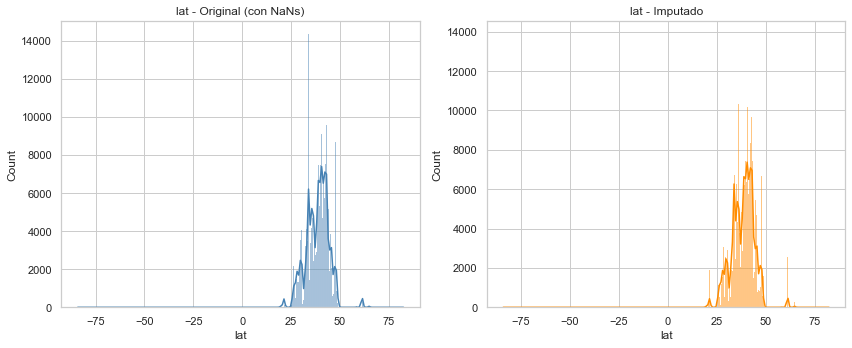

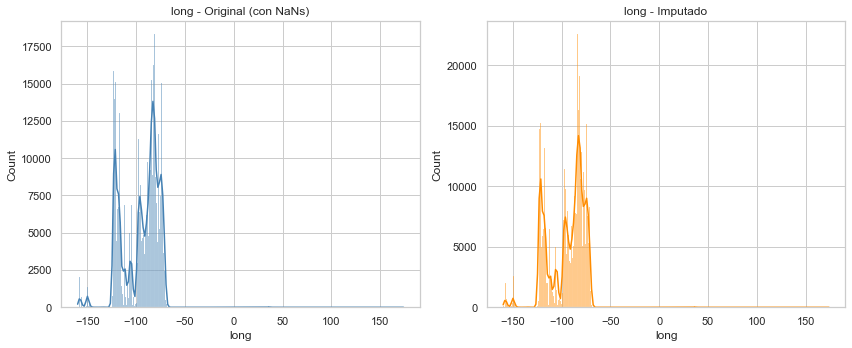

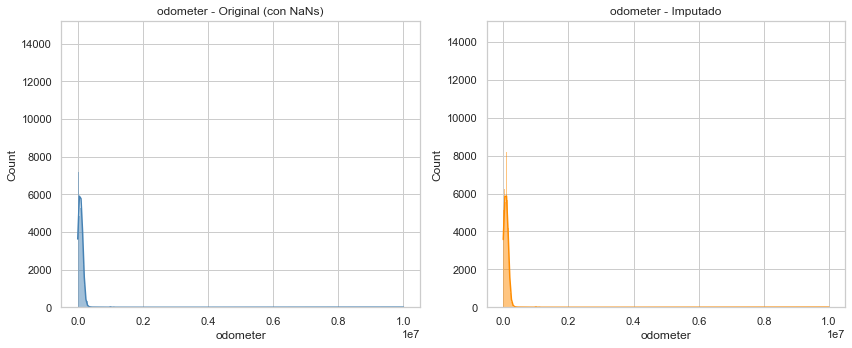

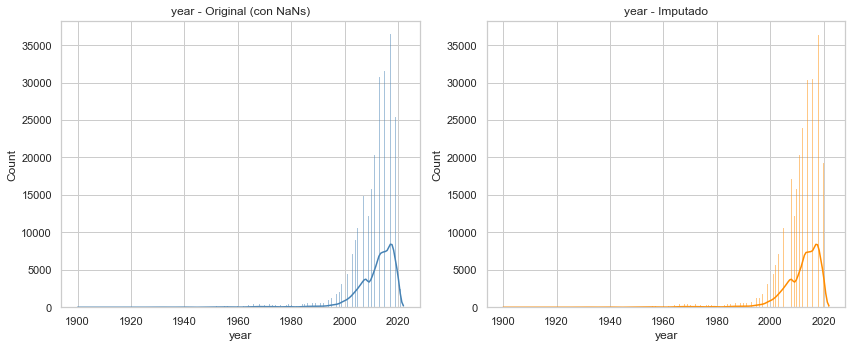

In [63]:
comparar_distribuciones_graf(df, df_imputado, var_low_NA_num)

* La variable `lat` mantiene una distribución consistente después de imputar, lo cual indica que la estrategia utilizada no alteró significativamente su comportamiento general. Esto sugiere que la imputación respetó la forma original de los datos.

* Para la variable `long`, la comparación muestra un patrón similar al caso anterior. Aunque hay ligeros cambios en la densidad, la forma principal de la distribución persiste, lo que refleja una imputación adecuada que conserva la estructura geográfica.

* En el caso de `odometer`, la distribución presenta una fuerte concentración en valores bajos tanto antes como después de imputar. Esto sugiere que los valores imputados no distorsionan los patrones típicos del kilometraje registrado.

* La variable `year` presenta una clara acumulación de datos en los años recientes en ambos gráficos. La imputación no modifica esa tendencia, lo que sugiere que la estrategia adoptada para completar los datos ausentes fue efectiva y consistente con la distribución original.

***3.3.3.4. Variables categóricas***

In [64]:
var_low_NA_cat = ["manufacturer", "title_status", "fuel", "transmission", "model"]

La lista `var_low_NA_cat` agrupa aquellas variables categóricas con menos del 5% de valores faltantes. Estas columnas serán analizadas posteriormente para imputación o evaluación de su distribución. 

In [65]:
resumen_categorias(df,"manufacturer")

,Conteo,Porcentaje (%)
ford,70985,16.63
chevrolet,55064,12.90
toyota,34202,8.01
honda,21269,4.98
nissan,19067,4.47
jeep,19014,4.45
ram,18342,4.30
NaN,17646,4.13
gmc,16785,3.93
bmw,14699,3.44


El resumen de la columna `manufacturer` muestra la distribución de marcas en el conjunto de datos. Ford, Chevrolet y Toyota son las marcas más frecuentes, acumulando entre las tres casi el 38% del total. La presencia de valores nulos (`NaN`) alcanza el 4.13%, lo cual confirma que la variable entra en el grupo de aquellas con baja proporción de faltantes. También destaca una larga cola de fabricantes con presencia marginal, donde varios aparecen con menos del 1% de representación, incluyendo casos casi anecdóticos como Morgan o Aston Martin. 

In [66]:
resumen_categorias(df,"title_status")

,Conteo,Porcentaje (%)
clean,405117,94.90
NaN,8242,1.93
rebuilt,7219,1.69
salvage,3868,0.91
lien,1422,0.33
missing,814,0.19
parts only,198,0.05


La tabla de frecuencia para la columna `title_status` evidencia que la mayoría de los vehículos tienen un título “clean”, representando el 94.90% del total. Las demás categorías como “rebuilt”, “salvage” o “lien” están presentes en proporciones considerablemente menores, y los valores faltantes apenas alcanzan el 1.93%. 

In [67]:
resumen_categorias(df,"fuel")

,Conteo,Porcentaje (%)
gas,356209,83.44
other,30728,7.20
diesel,30062,7.04
hybrid,5170,1.21
NaN,3013,0.71
electric,1698,0.40


La variable `fuel` muestra una clara mayoría de vehículos que usan gasolina, con un 83.44% de los registros. Las otras categorías como “other”, “diesel” e “hybrid” tienen menor presencia, mientras que los vehículos eléctricos apenas representan un 0.40% del total. 

In [68]:
resumen_categorias(df,"transmission")

,Conteo,Porcentaje (%)
automatic,336524,78.83
other,62682,14.68
manual,25118,5.88
NaN,2556,0.60


En la columna `transmission`, la mayoría de los vehículos cuentan con transmisión automática, sumando un 78.83% del total. Las transmisiones manuales sólo representan el 5.88%, y existe un 14.68% que cae en la categoría “other”. La proporción de valores nulos es de apenas 0.60%, lo cual permite incluir esta variable en análisis posteriores sin mayor tratamiento. 

In [69]:
resumen_categorias(df,"model")

,Conteo,Porcentaje (%)
f-150,8009,1.88
NaN,5277,1.24
silverado 1500,5140,1.20
1500,4211,0.99
camry,3135,0.73
...,...,...
Huyndai Sante Fe Limited,1,0.00
astro awd 4x4,1,0.00
escalade and,1,0.00
cx 3,1,0.00


La variable `model` contiene una gran cantidad de categorías distintas, lo que indica una alta cardinalidad. Aunque hay modelos relativamente comunes como “f-150” o “silverado 1500”, la mayoría de los registros se encuentran distribuidos entre cientos de modelos con muy baja frecuencia individual. Algunos modelos aparecen una sola vez.  Los valores faltantes representan un 1.24% del total.

In [70]:
df_imputado = imputar_por_moda(df,df_imputado, var_low_NA_cat)

Se realiza la imputación de valores faltantes en las variables categóricas con baja proporción de NA (`manufacturer`, `title_status`, `fuel`, `transmission`, `model`). El método usado es la moda, lo cual implica rellenar los valores ausentes con la categoría más frecuente en cada columna. 

In [71]:
df_imputado.isnull().values.any()

hay_na = df_imputado[var_low_NA_cat].isnull().values.any()
print(f"¿Hay NA en columnas imputadas? {hay_na}")

na_por_col = df_imputado[var_low_NA_cat].isnull().sum()
print("Conteo de NA por columna imputada:")
print(na_por_col)

¿Hay NA en columnas imputadas? False
Conteo de NA por columna imputada:
manufacturer    0
title_status    0
fuel            0
transmission    0
model           0
dtype: int64


Se verifica si aún quedan valores faltantes en el DataFrame imputado, tanto de forma general como específicamente en las columnas categóricas que fueron imputadas. La salida confirma que no hay valores faltantes restantes en estas variables, ya que todos los conteos son cero. Esto valida que la imputación por moda se aplicó correctamente, dejando el conjunto de datos listo para análisis o modelado sin problemas derivados de datos ausentes.


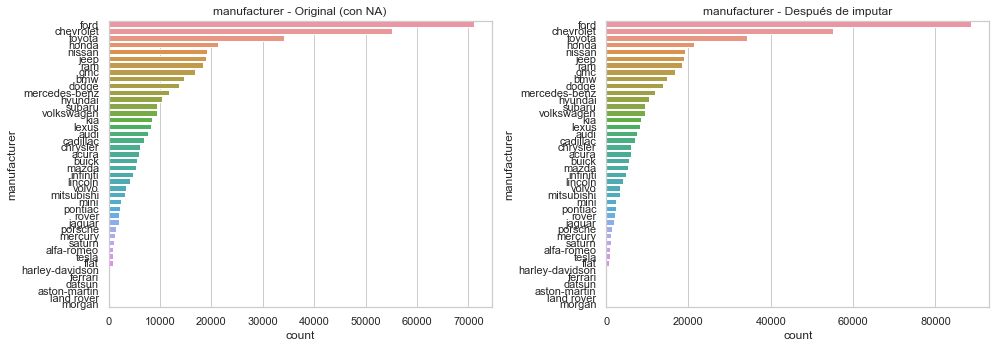

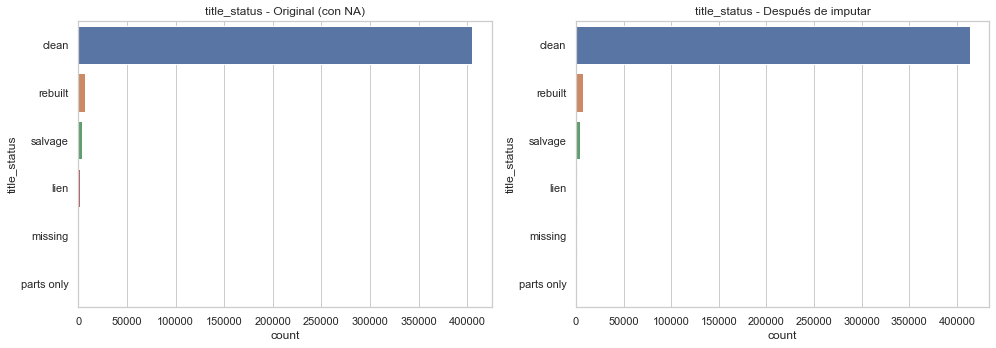

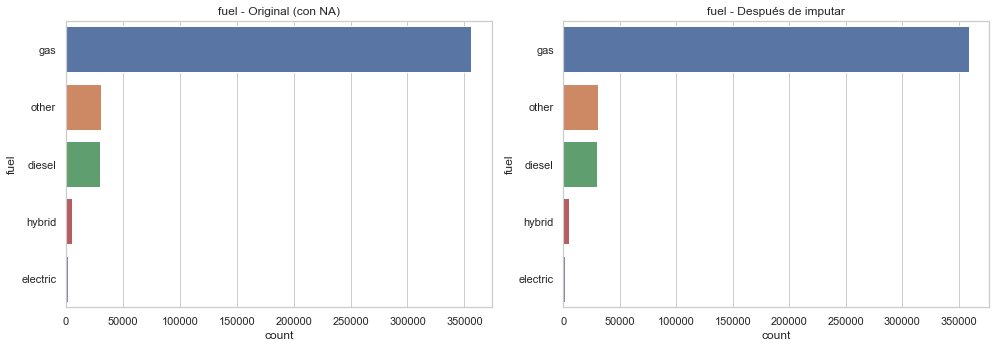

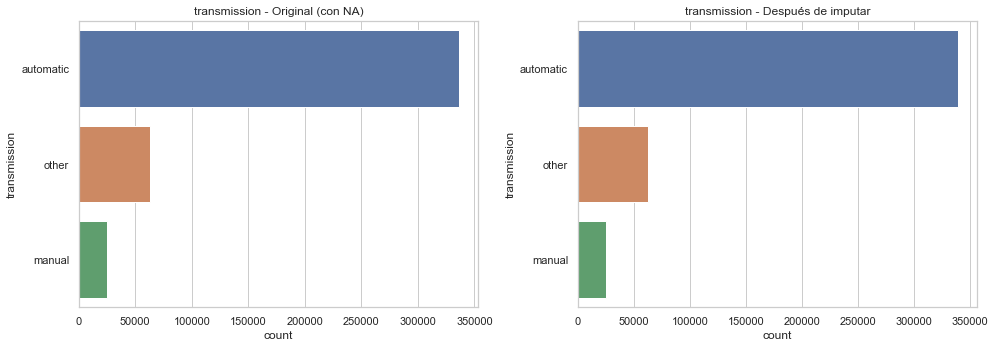

In [72]:
var_cargar = var_low_NA_cat = ["manufacturer", "title_status", "fuel", "transmission"]
comparar_categoricas(df, df_imputado, var_low_NA_cat)

La función `comparar_categoricas` genera gráficos comparativos de barras para visualizar la distribución de las categorías antes y después de la imputación. 
* En el caso de la variable `manufacturer`, se observa que la distribución no cambia de forma significativa luego de imputar, lo cual indica que los valores ausentes fueron reemplazados por la categoría más frecuente, sin alterar el perfil general de la variable.
* En la variable `title_status`, la categoría predominante es "clean", y esta también es la que fue utilizada para imputar los valores faltantes. El gráfico posterior a la imputación muestra un leve incremento en la altura de esta barra, correspondiente a los datos faltantes que fueron reemplazados. La distribución general permanece prácticamente idéntica.
* Para la variable `fuel`, se nota que "gas" es, con gran diferencia, la categoría más común. Como era de esperarse, los valores ausentes fueron reemplazados por esta categoría mayoritaria. La gráfica después de imputar presenta un ligero aumento en la barra de "gas", manteniéndose estable el resto de la distribución.
* La variable `transmission` muestra que la mayoría de los registros tienen transmisión automática. Al imputar los valores faltantes, la barra correspondiente a "automatic" crece un poco, lo que indica que fue la categoría usada para rellenar los NA. La distribución original se conserva, con apenas una mínima alteración.

### ***3.3.4. Verificación de valores faltantes***

In [73]:
def resumen_faltantes(df):
    faltantes = df.isnull().sum()
    porcentaje = (faltantes / len(df)) * 100

    tabla_faltantes = pd.DataFrame({
        'Valores faltantes': faltantes,
        'Porcentaje (%)': porcentaje
    })

    # Filtrar solo las columnas que tienen NA
    tabla_faltantes = tabla_faltantes[tabla_faltantes['Valores faltantes'] > 0]
    
    # Ordenar por porcentaje descendente
    tabla_faltantes = tabla_faltantes.sort_values('Porcentaje (%)', ascending=False)

    return tabla_faltantes

La función `resumen_faltantes` calcula el total y porcentaje de valores faltantes en cada columna del DataFrame. Crea un DataFrame que contiene esta información, filtra para mostrar solo las columnas con valores faltantes y ordena el resultado en orden descendente según el porcentaje.

In [74]:
resumen_faltantes(df_imputado)

,Valores faltantes,Porcentaje (%)


La llamada a `resumen_faltantes` con el DataFrame imputado verifica que no existen valores faltantes tras la limpieza y la imputación. El resultado indica que el DataFrame está completamente limpio, sin valores nulos, lo cual confirma la correcta ejecución del proceso previo.


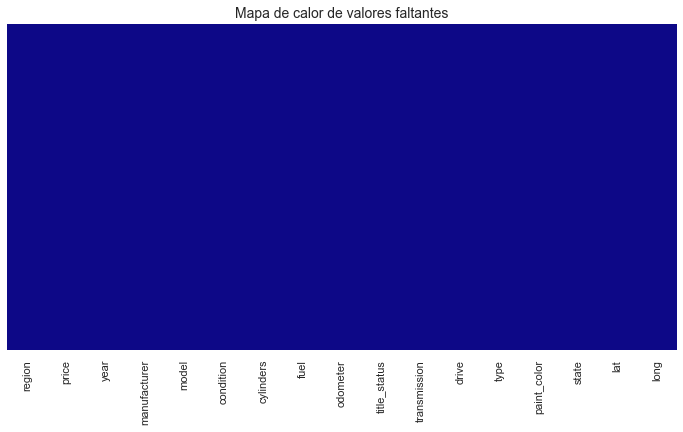

In [75]:
plt.figure(figsize=(12, 6))
sns.heatmap(df_imputado.isnull(), cbar=False, yticklabels=False, cmap='plasma')
plt.title("Mapa de calor de valores faltantes", fontsize=14)
plt.show()

El mapa de calor generado con `sns.heatmap` visualiza la ausencia de valores faltantes en el DataFrame imputado. La ausencia de zonas coloreadas indica que ninguna columna contiene datos faltantes, corroborando la limpieza total de datos nulos y validando el estado óptimo del conjunto de datos para análisis posteriores.


### **3.5. Codificación de variables categóricas**

In [76]:
from sklearn.preprocessing import OneHotEncoder

def codificar_one_hot_sklearn(df_imputado, columnas_categoricas):
    df_imputado = df_imputado.copy()
    df_cat = df_imputado[columnas_categoricas]
    df_num = df_imputado.drop(columns=columnas_categoricas)

    encoder = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
    encoded_array = encoder.fit_transform(df_cat)

    encoded_cols = encoder.get_feature_names_out(columnas_categoricas)
    df_encoded_cat = pd.DataFrame(encoded_array, columns=encoded_cols, index=df_imputado.index)

    df_encoded = pd.concat([df_num, df_encoded_cat], axis=1)
    return df_encoded, encoder

Esta función codifica variables categóricas en un DataFrame usando OneHotEncoder de sklearn. Primero crea copias de las columnas categóricas y las numéricas para mantener los datos originales intactos. Luego aplica el codificador para transformar las variables categóricas en variables binarias (one-hot encoding). Finalmente, concatena las variables numéricas con las codificadas y devuelve el DataFrame resultante junto con el objeto encoder para uso posterior.


In [77]:
columnas_categoricas = ['region', 'manufacturer', 'model', 'condition', 'fuel', 'title_status','transmission', 'drive', 'type', 'paint_color', 'state']

Acá se define una lista con las columnas categóricas que serán codificadas y procesadas. Incluye atributos como región, fabricante, modelo, condición, tipo de combustible, estado del título, transmisión, tipo de conducción, color y estado del vehículo. 

In [78]:
def agrupar_categorias_rare(df, columnas, threshold=0.01, nombre_otros='Other'):
    df_modificado = df.copy()
    for col in columnas:
        if col in df_modificado.columns:
            freqs = df_modificado[col].value_counts(normalize=True)
            categorias_a_agrupadas = freqs[freqs < threshold].index

            df_modificado[col] = df_modificado[col].apply(
                lambda x: nombre_otros if x in categorias_a_agrupadas else x
            )

            # Si la columna es categórica, actualiza las categorías
            if df_modificado[col].dtype.name == 'category':
                df_modificado[col] = df_modificado[col].cat.add_categories([nombre_otros])
                df_modificado[col] = df_modificado[col].cat.remove_unused_categories()
                
    return df_modificado


Función que agrupa categorías poco frecuentes dentro de variables categóricas para evitar que el modelo se disperse con muchas categorías raras. Copia el DataFrame original y analiza cada columna especificada para identificar las categorías cuya frecuencia relativa es menor que un umbral dado. Estas categorías raras se agrupan bajo una etiqueta común, como 'Other'. También actualiza el tipo categórico para reflejar los cambios en las categorías disponibles.

In [79]:
columnas_cat_redu = ['manufacturer', 'model', 'condition', 'fuel', 'title_status','transmission', 'drive', 'type', 'paint_color', 'state']

Se define una lista de columnas categóricas reducidas, excluyendo algunas de la lista original para enfocarse en variables con mayor relevancia o menor cantidad de categorías. Esta selección se utiliza para aplicar la función de agrupación de categorías raras, optimizando así la representación de los datos y mejorando la eficiencia del modelo.


In [80]:
df_reducido = agrupar_categorias_rare(df_imputado, columnas_cat_redu, threshold=0.01)

Aquí se crea una función para revisar qué valores únicos tiene cada columna que le pases, y te dice cuántos hay. También avisa si alguna columna no está en el DataFrame. Sirve para entender rápido qué categorías hay en cada columna.

In [81]:
def mostrar_categorias_y_cuenta(df, columnas):
    resultados = {}

    for col in columnas:
        if col in df.columns:
            categorias = df[col].dropna().unique()
            resultados[col] = (list(categorias), len(categorias))
        else:
            print(f"Columna '{col}' no encontrada en el DataFrame.")

    return resultados


Se usa la función con un DataFrame y un grupo de columnas que son categóricas. Después imprime los resultados para ver qué valores hay y cuántos por cada columna. 

In [82]:
categorias = mostrar_categorias_y_cuenta(df_reducido, columnas_categoricas)

for col, cats in categorias.items():
    print(f"{col}: {cats}")


region: (['prescott', 'fayetteville', 'florida keys', 'worcester / central MA', 'greensboro', 'hudson valley', 'medford-ashland', 'erie', 'el paso', 'bellingham', 'skagit / island / SJI', 'la crosse', 'auburn', 'birmingham', 'dothan', 'florence / muscle shoals', 'gadsden-anniston', 'huntsville / decatur', 'mobile', 'montgomery', 'tuscaloosa', 'anchorage / mat-su', 'fairbanks', 'kenai peninsula', 'southeast alaska', 'flagstaff / sedona', 'mohave county', 'phoenix', 'show low', 'sierra vista', 'tucson', 'yuma', 'fort smith', 'jonesboro', 'little rock', 'texarkana', 'bakersfield', 'chico', 'fresno / madera', 'gold country', 'hanford-corcoran', 'humboldt county', 'imperial county', 'inland empire', 'los angeles', 'mendocino county', 'merced', 'modesto', 'monterey bay', 'orange county', 'palm springs', 'redding', 'reno / tahoe', 'sacramento', 'san diego', 'san luis obispo', 'santa barbara', 'santa maria', 'SF bay area', 'siskiyou county', 'stockton', 'susanville', 'ventura county', 'visalia

Esta es la salida que muestra algunas columnas con sus valores únicos y cuántos tiene cada uno. 

In [83]:
resumen_categorias(df_reducido, 'model')

,Conteo,Porcentaje (%)
Other,408454,95.68
f-150,13286,3.11
silverado 1500,5140,1.20


Aquí se observan como quedaron finalmente las categorías de la variable model.

## ***4. Actualización de la base de datos***

Finalmente, se guarda el DataFrame limpio en un archivo CSV para poder usarlo después.

In [84]:
df_reducido.to_csv("limpio_miniproyecto_3.csv",index=False, encoding="utf-8")